In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install pytorch-forecasting

In [2]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import torch
import pytorch_lightning as pl
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_forecasting.metrics import NormalDistributionLoss
from pytorch_forecasting import TimeSeriesDataSet, Baseline, NBeats, GroupNormalizer, MultiNormalizer, EncoderNormalizer
from pytorch_forecasting.data.encoders import TorchNormalizer

torch.multiprocessing.set_sharing_strategy('file_system')
# from gluonts.dataset.common import load_datasets, ListDataset
# from gluonts.dataset.field_names import FieldName
# from gluonts.evaluation.backtest import make_evaluation_predictions
# # from gluonts.trainer import Trainer
# from gluonts.model.n_beats import NBEATSEnsembleEstimator
# from gluonts.evaluation import Evaluator

In [3]:
#config
EPOCHS = 1
VAL_PERC = .1
TEST_PERC = .005
BATCH_SIZE = 32

LAG_TIME = 96
LEAD_TIME = 28

In [4]:
first_n=1000
df=pd.read_pickle("m5_aggregate_df.pkl")
df=df.loc[df['id'].isin(df['id'].unique()[0:first_n])]
df.head()


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,cat_sold_avg,dept_sold_avg,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg,rolling_sold_mean
1067150,14370,1437,3,1,0,0,36,0,2011-03-05,11106,...,0.561035,0.695801,0.695801,0.321533,0.216553,0.216553,1.304688,0.801758,1.020508,1.142578
1067151,14380,1438,3,1,0,0,36,0,2011-03-05,11106,...,0.561035,0.695801,0.695801,0.253906,0.259766,0.259766,1.304688,0.801758,1.020508,1.142578
1067152,14390,1439,3,1,0,0,36,0,2011-03-05,11106,...,0.561035,0.695801,0.695801,0.156982,0.076660,0.076660,1.304688,0.801758,1.020508,0.428467
1067153,14400,1440,3,1,0,0,36,0,2011-03-05,11106,...,0.561035,0.695801,0.695801,1.694336,2.011719,2.011719,1.304688,0.801758,1.020508,0.285645
1067154,14410,1441,3,1,0,0,36,0,2011-03-05,11106,...,0.561035,0.695801,0.695801,0.958984,0.755371,0.755371,1.304688,0.801758,1.020508,0.000000


In [5]:
df=df[['id','date','sold']].pivot_table(values='sold', index=['date'],columns=['id'], aggfunc=np.sum)


In [6]:
df

id,14370,14380,14390,14400,14410,14420,14430,14440,14450,14460,...,24270,24280,24290,24300,24310,24320,24330,24340,24350,24360
date,,,,,,,,,,,,,,,,,,,,,
2011-03-05,0,0,0,0,0,0,0,0,7,0,...,0,2,0,0,2,0,0,0,2,0
2011-03-06,0,0,0,2,0,0,0,4,1,0,...,0,8,0,7,1,4,0,0,0,0
2011-03-07,0,0,0,0,0,0,0,0,8,0,...,0,1,0,1,1,3,0,0,0,0
2011-03-08,0,0,0,0,0,0,0,0,6,0,...,0,1,0,1,3,1,0,0,0,0
2011-03-09,0,0,0,0,0,0,0,0,0,0,...,0,2,0,1,8,1,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-06-16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-06-17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
VAL_PERC=.1
TEST_PERC=.1
n_samples = len(df)
n_val = int(n_samples * VAL_PERC)
n_test = int(n_samples * TEST_PERC)
n_train = n_samples - (n_val + n_test)

# Split data into train and test
train_df = df.iloc[:n_train, :]
val_df = df.iloc[n_train:n_train+n_val]
test_df = df.iloc[n_train+n_val:]
# test_df = test_df.iloc[:150]



In [8]:
# test_df.iloc[:28]

In [9]:
# Rename index to time_idx
train_df = train_df.reset_index().reset_index().rename({'index':'time_idx'}, axis=1)
val_df = val_df.reset_index().reset_index().rename({'index':'time_idx'}, axis=1)
test_df = test_df.reset_index().reset_index().rename({'index':'time_idx'}, axis=1)

train_df['group_ids'] = 0
val_df['group_ids'] = 0
test_df['group_ids'] = 0

In [10]:
# Reshape data into single value column that is uniquely indexed by pairs of (time_idx, group_ids).
train_df = train_df.melt(id_vars=['time_idx', 'date'], value_vars=df.columns, var_name='group_ids')
val_df = val_df.melt(id_vars=['time_idx', 'date'], value_vars=df.columns, var_name='group_ids')
test_df = test_df.melt(id_vars=['time_idx', 'date'], value_vars=df.columns, var_name='group_ids')

In [11]:
train_df['value'] = train_df['value'].astype(float)
val_df['value'] = val_df['value'].astype(float)
test_df['value'] = test_df['value'].astype(float)
test_df.dtypes



time_idx              int64
date         datetime64[ns]
group_ids            object
value               float64
dtype: object

In [12]:
# Define datasets
train_data = TimeSeriesDataSet(
    data=train_df,  
    time_idx="time_idx",
    target="value",
    categorical_encoders={"group_ids": NaNLabelEncoder().fit(train_df.group_ids)},
    group_ids=['group_ids'],
    max_encoder_length=LAG_TIME,
    max_prediction_length=LEAD_TIME,
    time_varying_unknown_reals=["value"],
#     target_normalizer= TorchNormalizer() 
)

val_data = TimeSeriesDataSet(
    data=val_df,  
    time_idx="time_idx",
    target="value",
    categorical_encoders={"group_ids": NaNLabelEncoder().fit(val_df.group_ids)},
    group_ids=['group_ids'],
    max_encoder_length=LAG_TIME,
    max_prediction_length=LEAD_TIME,
    time_varying_unknown_reals=["value"],
#     target_normalizer= TorchNormalizer()
)

test_data = TimeSeriesDataSet(
    data=test_df,  
    time_idx="time_idx",
    target="value",
    categorical_encoders={"group_ids": NaNLabelEncoder().fit(test_df.group_ids)},
    group_ids=['group_ids'],
    max_encoder_length=LAG_TIME,
    max_prediction_length=LEAD_TIME,
    time_varying_unknown_reals=["value"],
#     target_normalizer= TorchNormalizer()
)

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:618: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:618: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:618: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


In [13]:
# Define dataloader
train_dataloader = train_data.to_dataloader(train=True, batch_size=BATCH_SIZE, num_workers=4)
val_dataloader = val_data.to_dataloader(train=False, batch_size=BATCH_SIZE, num_workers=4)
test_dataloader = test_data.to_dataloader(train=False, batch_size=BATCH_SIZE, num_workers=4)

In [14]:
isinstance(train_data.target_normalizer, NaNLabelEncoder)

False

In [15]:
# Init model with structure specified in dataset
net = NBeats.from_dataset(
    train_data,
    learning_rate=2e-4,
    weight_decay=1e-2
)

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/models/nbeats/sub_modules.py:154: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  coefficients = torch.tensor([backcast_linspace ** i for i in range(thetas_dim)], dtype=torch.float32)


In [16]:
# Set random seed 
pl.seed_everything(42)

# Define early stopping criteria
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")

# Init pytorch lightning trainer
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    gpus=1,
    weights_summary="top",
    callbacks=[early_stop_callback],
    limit_train_batches=.2,
    limit_val_batches=.2,
)


# Train and Validate Model
trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader
)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.8 M 
-----------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.135     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
Global seed set to 42


Training: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with highe

Validating: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with highe

In [17]:
# Load best model from checkpoint
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [18]:
del train_data,val_data

In [19]:
# Get predictions from test dataset
preds = best_model.predict(test_dataloader)

# Aggregate inputs, ground truth and classes into tensor alligned with predictions
input_list, true_list, class_list = [], [], []
for x, y in test_dataloader: 
    input_list.append(x["encoder_target"])
    true_list.append(y[0])
    class_list.append(x["groups"])


inputs = torch.cat(input_list)
trues = torch.cat(true_list)
classes = torch.cat(class_list)

print(inputs.shape, preds.shape, trues.shape, classes.shape)

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with highe

torch.Size([70000, 96]) torch.Size([70000, 28]) torch.Size([70000, 28]) torch.Size([70000, 1])


In [21]:
# error_nbeats = np.linalg.norm(preds - trues)/len(preds[0])
# error_nbeats
mae_error=mean_absolute_error(trues,preds)
rmse_error=np.sqrt(mean_squared_error(trues,preds))
print(mae_error)
print(rmse_error)

0.87523717
1.9406703


In [ ]:
# test_df.shape

In [ ]:
# preds.shape

In [ ]:
# torch.multiprocessing.set_sharing_strategy('file_system')

In [ ]:
# torch.multiprocessing.get_sharing_strategy()

In [ ]:
# torch.multiprocessing.get_all_sharing_strategies()

In [22]:
# Select indices of samples to visualize
n_samples = 10
ss_indices = np.random.choice(range(preds.shape[0]), n_samples, replace=False)
ss_pred = preds[ss_indices]
ss_true = trues[ss_indices]
ss_input = inputs[ss_indices]
ss_class = classes[ss_indices]

print(ss_input.shape, ss_pred.shape, ss_true.shape, ss_class.shape)

torch.Size([10, 96]) torch.Size([10, 28]) torch.Size([10, 28]) torch.Size([10, 1])


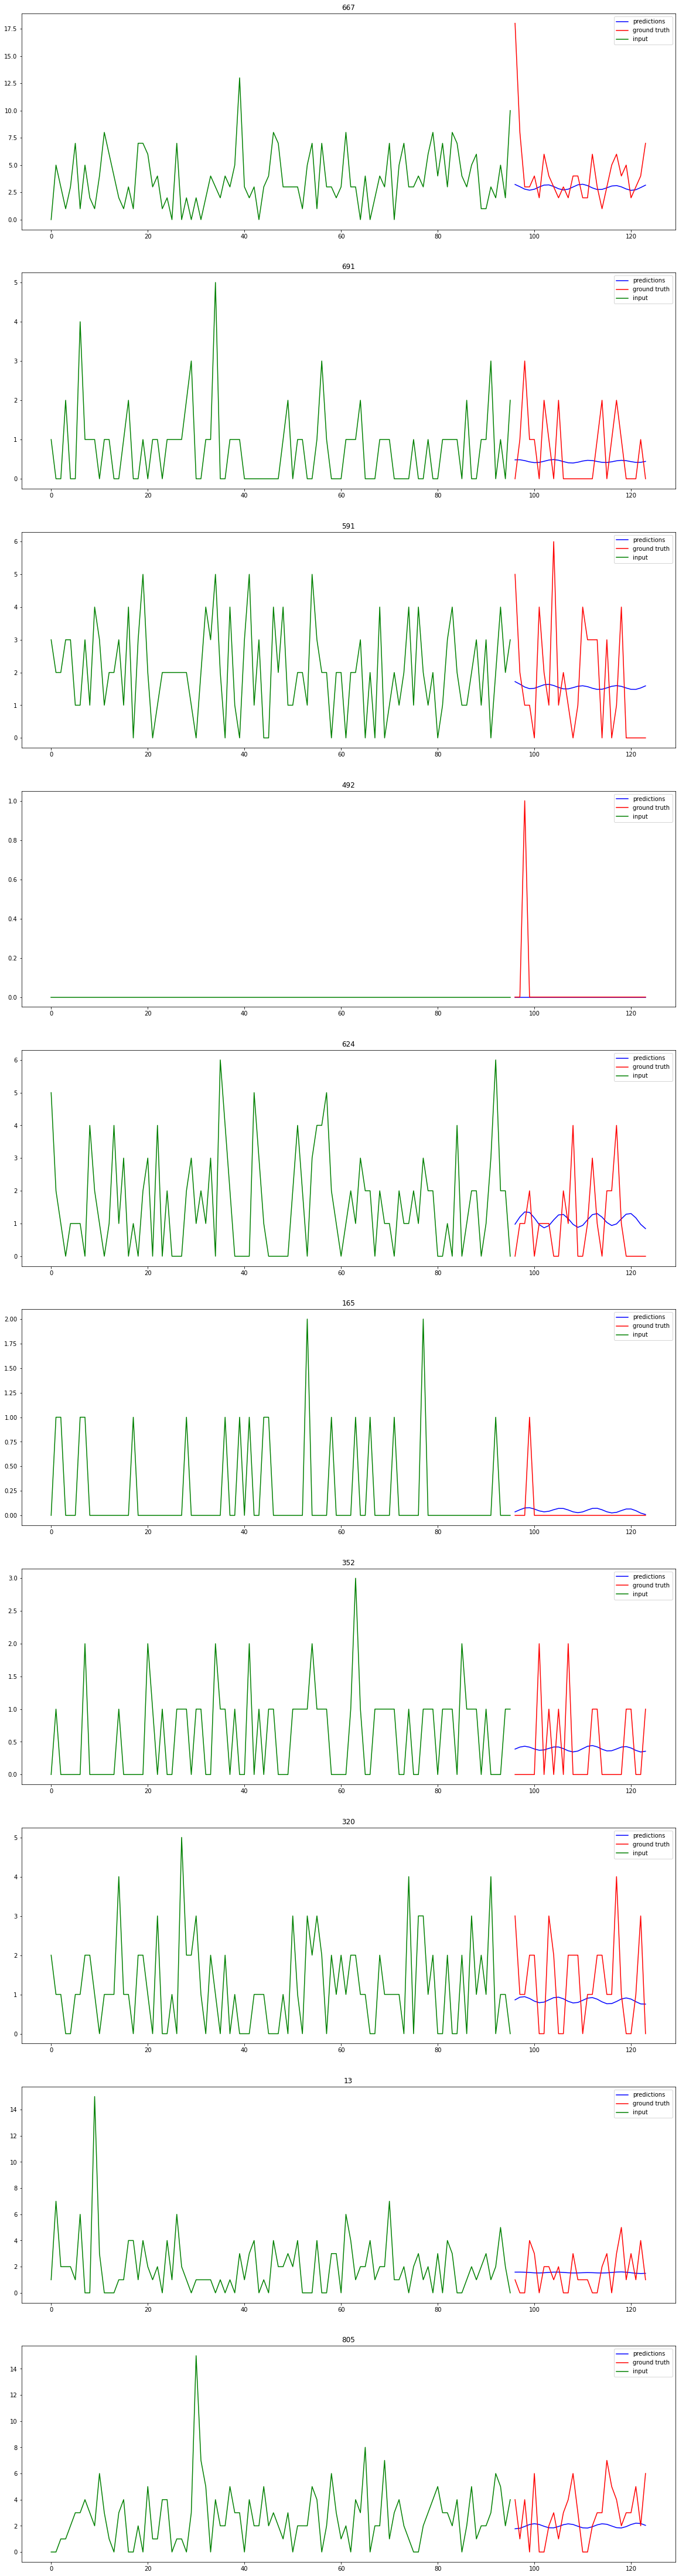

In [23]:
# Loop through samples and plot input, ground truth and prediction
f, axarr = plt.subplots(n_samples, 1, figsize=(20, 80))
for i in range(n_samples):
    series_preds = ss_pred[i, :].squeeze()
    series_trues = ss_true[i, :].squeeze()
    series_inputs = ss_input[i, :].squeeze()

    feat_name = str(ss_class[i].item())
    
    input_len = series_inputs.shape[0]
    pred_gt_len = series_preds.shape[0]
    input_x = np.array([i for i in range(input_len)])
    x = np.array([i for i in range(input_len, input_len+pred_gt_len)])
    axarr[i].plot(x, series_preds, c="blue", label="predictions")
    axarr[i].plot(x, series_trues, c="red", label="ground truth")
    axarr[i].plot(input_x, series_inputs, c="green", label="input")
    axarr[i].legend()
    axarr[i].set_title(feat_name)